<a href="https://colab.research.google.com/github/DilemmaFixer3/AI_pr_5-6-7/blob/main/pr_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow Version: 2.19.0
Eager execution: True
GPU Available: []


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,081 (19.85 KB)

 Trainable params: 5,081 (19.85 KB)

 Non-trainable params: 0 (0.00 B)


--- Початок навчання за допомогою Adam ---


Епоха 1000/20000 | Час: 157.37s
  Заг. Втрата: 7.463948e-03 | PDE: 3.630147e-04 | IC: 5.662067e-03 | BC: 1.438866e-03
Епоха 2000/20000 | Час: 153.68s
  Заг. Втрата: 5.721675e-03 | PDE: 2.204649e-04 | IC: 4.521354e-03 | BC: 9.798566e-04
Епоха 3000/20000 | Час: 152.45s
  Заг. Втрата: 3.770428e-03 | PDE: 3.117750e-04 | IC: 2.579395e-03 | BC: 8.792574e-04
Епоха 4000/20000 | Час: 152.14s
  Заг. Втрата: 5.224984e-03 | PDE: 4.200745e-04 | IC: 2.595321e-03 | BC: 2.209589e-03
Епоха 5000/20000 | Час: 152.97s
  Заг. Втрата: 2.049931e-03 | PDE: 2.110870e-04 | IC: 1.298945e-03 | BC: 5.398992e-04
Епоха 6000/20000 | Час: 153.82s
  Заг. Втрата: 1.714906e-03 | PDE: 1.850818e-04 | IC: 1.065829e-03 | BC: 4.639955e-04
Епоха 7000/20000 | Час: 146.19s
  Заг. Втрата: 1.476270e-03 | PDE: 1.525266e-04 | IC: 9.035622e-04 | BC: 4.201814e-04
Епоха 8000/20000 | Час: 139.54s
  Заг. Втрата: 1.281649e-03 | PDE: 1.274271e-04 | IC: 7.797766e-04 | BC: 3.744448e-04
Епоха 9000/20000 | Час: 137.10s
  Заг. Втрата: 1.164853e

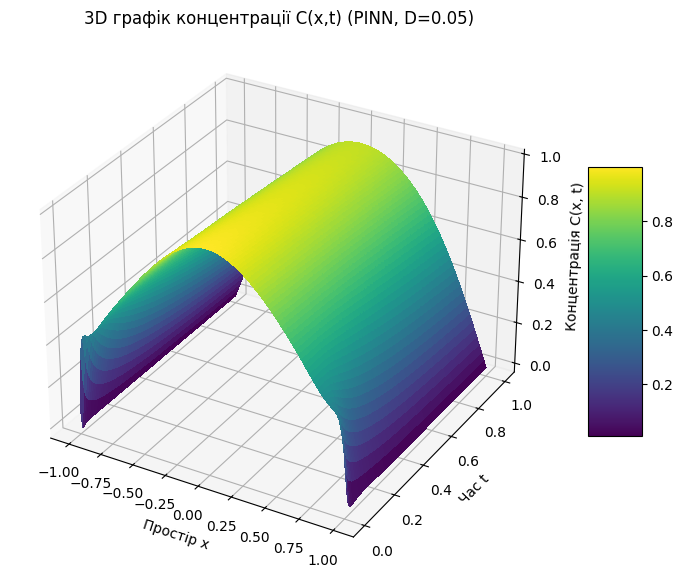

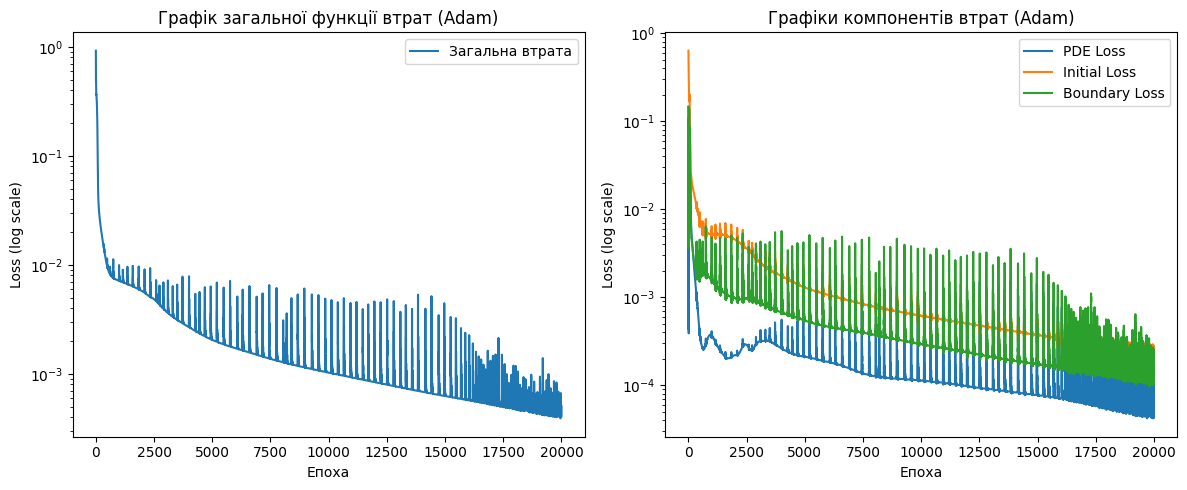

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


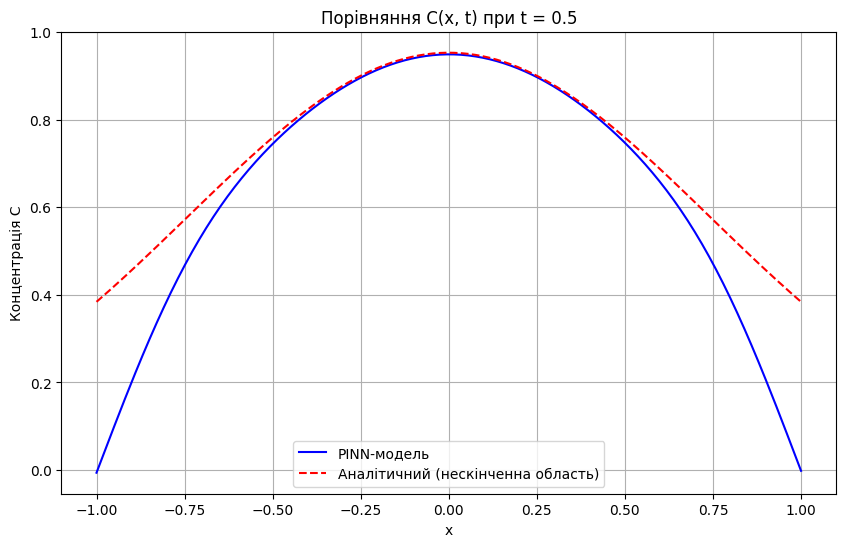

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

# Перевірка наявності GPU
print("TensorFlow Version:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# --- 1. Параметри Задачі (Варіант 2) ---
D = 0.05       # Коефіцієнт дифузії
x_min, x_max = -1.0, 1.0  # Просторовий інтервал [a, b]
t_min, t_max = 0.0, 1.0   # Часовий інтервал [0, T_max]

# Кількість точок для навчання
N_f = 20000  # Точки для PDE Loss (фізичні точки)
N_ic = 200   # Точки для Initial Loss (початкові умови)
N_bc = 100   # Точки для Boundary Loss (граничні умови)

# --- 2. Визначення Нейронної Мережі ---
def create_pinn_model():
    """Створює глибоку нейронну мережу для апроксимації C(x, t)."""

    # 2 входи: (x, t)
    input_layer = tf.keras.layers.Input(shape=(2,))

    # Рекомендована архітектура: 4 шари по 40 нейронів, активація 'tanh'
    hidden = input_layer
    for _ in range(4):
        # Використання 'tanh' для гладкості, необхідної для похідних
        hidden = tf.keras.layers.Dense(40, activation='tanh',
                                       kernel_initializer='glorot_normal')(hidden)

    # 1 вихід: C(x, t)
    output_layer = tf.keras.layers.Dense(1, activation='linear',
                                         kernel_initializer='glorot_normal')(hidden)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Ініціалізація моделі
model = create_pinn_model()
model.summary()

# --- 3. Генерація Тренувальних Даних ---

# 3.1 Точки для PDE Loss (Physics Loss): випадкові точки в області [x_min, x_max] x [t_min, t_max]
# Примітка: t_min > 0, оскільки початкова умова обробляється окремо.
X_f = tf.random.uniform((N_f, 1), minval=x_min, maxval=x_max, dtype=tf.float32)
T_f = tf.random.uniform((N_f, 1), minval=t_min, maxval=t_max, dtype=tf.float32)
X_train_f = tf.concat([X_f, T_f], axis=1)

# 3.2 Точки для Initial Loss (Початкові умови): t = 0
X_ic = tf.random.uniform((N_ic, 1), minval=x_min, maxval=x_max, dtype=tf.float32)
T_ic = tf.zeros_like(X_ic, dtype=tf.float32)
X_train_ic = tf.concat([X_ic, T_ic], axis=1)
C_ic_true = tf.exp(-X_ic**2) # C(x, 0) = e^(-x^2)

# 3.3 Точки для Boundary Loss (Граничні умови): x = -1 або x = 1
# Ліва межа (x = -1)
T_bc_L = tf.random.uniform((N_bc, 1), minval=t_min, maxval=t_max, dtype=tf.float32)
X_bc_L = tf.ones_like(T_bc_L, dtype=tf.float32) * x_min
X_train_bc_L = tf.concat([X_bc_L, T_bc_L], axis=1)
# Права межа (x = 1)
T_bc_R = tf.random.uniform((N_bc, 1), minval=t_min, maxval=t_max, dtype=tf.float32)
X_bc_R = tf.ones_like(T_bc_R, dtype=tf.float32) * x_max
X_train_bc_R = tf.concat([X_bc_R, T_bc_R], axis=1)
# Істинне значення (C(-1, t) = 0, C(1, t) = 0)
C_bc_true = tf.zeros((N_bc, 1), dtype=tf.float32)


# --- 4. Функція Втрат та Градієнти ---

@tf.function
def pinn_loss(X_f, X_ic, C_ic_true, X_bc_L, X_bc_R, C_bc_true):
    """Обчислює загальну функцію втрат PINN."""

    # 4.1 PDE Loss (Фізичний компонент)
    with tf.GradientTape(persistent=True) as tape:
        # Відстежуємо вхідні змінні для обчислення похідних
        tape.watch(X_f)

        # Вихід мережі C(x, t)
        C = model(X_f)

        # Обчислення перших похідних (dC/dx та dC/dt)
        C_x_t = tape.gradient(C, X_f)
        C_x = C_x_t[:, 0:1] # dC/dx
        C_t = C_x_t[:, 1:2] # dC/dt

    # Обчислення другої похідної (d^2C/dx^2)
    C_xx = tape.gradient(C_x, X_f)[:, 0:1]

    del tape # Видаляємо tape для звільнення пам'яті

    # Залишок дифузійного рівняння (Residual): R = dC/dt - D * d^2C/dx^2
    R = C_t - D * C_xx
    L_PDE = tf.reduce_mean(tf.square(R)) # MSE

    # 4.2 Initial Loss (Початкові умови)
    C_ic_pred = model(X_ic)
    L_IC = tf.reduce_mean(tf.square(C_ic_pred - C_ic_true)) # MSE

    # 4.3 Boundary Loss (Граничні умови Діріхле C=0)
    C_bc_L_pred = model(X_bc_L)
    C_bc_R_pred = model(X_bc_R)

    L_BC_L = tf.reduce_mean(tf.square(C_bc_L_pred - C_bc_true))
    L_BC_R = tf.reduce_mean(tf.square(C_bc_R_pred - C_bc_true))
    L_BC = L_BC_L + L_BC_R

    # Загальна втрата (Зазвичай вагові коефіцієнти приймають 1)
    L_total = L_PDE + L_IC + L_BC

    return L_total, L_PDE, L_IC, L_BC


# --- 5. Процес Навчання (Оптимізатор Adam) ---

# Вибір оптимізатора
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
EPOCHS = 20000
history = {'loss': [], 'pde_loss': [], 'ic_loss': [], 'bc_loss': []}

@tf.function
def train_step():
    """Виконує один крок навчання."""
    with tf.GradientTape() as tape:
        L_total, L_PDE, L_IC, L_BC = pinn_loss(X_train_f, X_train_ic, C_ic_true,
                                               X_train_bc_L, X_train_bc_R, C_bc_true)

    # Обчислення градієнтів та оновлення ваг
    grads = tape.gradient(L_total, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return L_total, L_PDE, L_IC, L_BC

print("\n--- Початок навчання за допомогою Adam ---")
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    L_total, L_PDE, L_IC, L_BC = train_step()

    # Збереження історії
    history['loss'].append(L_total.numpy())
    history['pde_loss'].append(L_PDE.numpy())
    history['ic_loss'].append(L_IC.numpy())
    history['bc_loss'].append(L_BC.numpy())

    if epoch % 1000 == 0:
        elapsed = time.time() - start_time
        print(f"Епоха {epoch}/{EPOCHS} | Час: {elapsed:.2f}s")
        print(f"  Заг. Втрата: {L_total.numpy():.6e} | PDE: {L_PDE.numpy():.6e} | IC: {L_IC.numpy():.6e} | BC: {L_BC.numpy():.6e}")
        start_time = time.time()

print("--- Навчання завершено ---")

# --- 6. Візуалізація Результатів ---

# 6.1. Аналітичний розв'язок (для нескінченної області - лише для порівняння)
def analytic_solution(x, t, D):
    return (1.0 / np.sqrt(4 * D * t + 1)) * np.exp(-x**2 / (4 * D * t + 1))

# 6.2. 3D-графік C(x, t)

# Створення сітки для візуалізації
X_plot = np.linspace(x_min, x_max, 100)
T_plot = np.linspace(t_min, t_max, 100)
X_mesh, T_mesh = np.meshgrid(X_plot, T_plot)
XT_flat = np.vstack([X_mesh.flatten(), T_mesh.flatten()]).T

# Прогноз моделі
C_pred_flat = model.predict(XT_flat).flatten()
C_pred_mesh = C_pred_flat.reshape(X_mesh.shape)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_mesh, T_mesh, C_pred_mesh, cmap='viridis',
                       antialiased=False, rstride=1, cstride=1)
ax.set_xlabel('Простір x')
ax.set_ylabel('Час t')
ax.set_zlabel('Концентрація C(x, t)')
ax.set_title(f'3D графік концентрації C(x,t) (PINN, D={D})')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# 6.3. Графіки Втрат
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Загальна втрата')
plt.title('Графік загальної функції втрат (Adam)')
plt.xlabel('Епоха')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['pde_loss'], label='PDE Loss')
plt.plot(history['ic_loss'], label='Initial Loss')
plt.plot(history['bc_loss'], label='Boundary Loss')
plt.title('Графіки компонентів втрат (Adam)')
plt.xlabel('Епоха')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# 6.4. Порівняння з Аналітичним Розв'язком при t = 0.5

t_test = 0.5
X_test = np.linspace(x_min, x_max, 200)
T_test = np.ones_like(X_test) * t_test
XT_test = np.vstack([X_test, T_test]).T

C_pred_test = model.predict(XT_test).flatten()
C_analytic_test = analytic_solution(X_test, t_test, D)

plt.figure(figsize=(10, 6))
plt.plot(X_test, C_pred_test, label='PINN-модель', color='blue')
# Аналітичний розв'язок як орієнтир
plt.plot(X_test, C_analytic_test, '--', label='Аналітичний (нескінченна область)', color='red')
plt.title(f'Порівняння C(x, t) при t = {t_test}')
plt.xlabel('x')
plt.ylabel('Концентрація C')
plt.grid(True)
plt.legend()
plt.show()